## Premier League’s Project

### We will go through an end to end Premier League’s Project Here are the main steps we will go through:
<h5><a href="#preprocessing_data">1. preprocessing data.</a></h5>
<h5><a href="#team_class">2. Create team class.</a></h5>
<h5><a href="#match_class">3. Create match class.</a></h5>
<h5><a href="#create_teams">4. Create teams.</a></h5>
<h5><a href="#create_matches">5. Create matches.</a></h5>
<h5><a href="#create_graph">6. Construct graph.</a></h5>
<h5><a href="#main">7. The main.</a></h5>

<div name="preprocessing_data" id="preprocessing_data"><h2>preprocessing data</h2></div>

in preprocessing data step we created `preprocess_data()` function that read the data from the file and do some preprocessing steps :

1. Convert date column which was `str` to `Datetime` object
2. add match number ( for matches in the same week )
3. Drop unnecessary data -> `Result` column ( as we can calculate it ) -> Drop `NaN` rows if available -> Drop rows have " - " in it's goals
4. Convert `HomeGoals` and `AwayGoals` columns' datatype from `str` to `int`
5. Sort the Dataframe based on Week number then by date
6. Convert Dataframe to list
**Time complexity :**
- `preprocess_data()` takes **`O(NlogN)`** which N is number of matches due to sorting  

In [6]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import networkx as nx
import math
path = r"E:\epl_results.csv"
def preprocess_data(path:str=path):
    """
    Preprocess data like date convert, drop unnecessary data , sort data and add some columns
    Args:Path to data file
    Return : list of matches and dataframe of matches
    """
    # Read data from csv file and save it in DataFrame
    df = pd.read_csv(path)
    # Convert `Date` from `str` to `Datetime` 
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    # add match number ( for matches in the same week )
    df['N'] = 0
    # Drop unnecessary data
    df = df.drop('Result', axis=1) # drop Result column
    df = df.dropna() # drop nan rows
    df = df.drop(df[df['HomeGoals'] == '-'].index) # drop rows that have'nt HomeGoals value
    df = df.drop(df[df['AwayGoals'] == '-'].index) # drop rows that have'nt AwayGoals value
    df['HomeGoals'] = df['HomeGoals'].astype(int)
    df['AwayGoals'] = df['AwayGoals'].astype(int)
    # Sort the Dataframe based on Week number then by date
    df = df.sort_values(by=['W','Date'],ascending=True)

    # set values for match number
    for value in df['W'].unique():
        matches = df[df['W'] == value].index
        df.loc[matches, 'N'] = range(1, len(matches) + 1)
    #Convert Dataframe to list
    matches_list = [df.iloc[i].tolist() for i in range(len(df))]
    return matches_list,df


In [7]:
matches_list , df = preprocess_data()
df.info()

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\epl_results.csv'

<div name="team_class" id="team_class"><h2>Create Team class</h2></div>

We construct `Team` class that take `name` , `matches_played` , `wins` , `draws` , `losses` , `points` , `goals_scored` and `goals_conceded` and have methods like:
1. `display()` : Display the team's data in `Dataframe` or `str` format
2. `add_win()` : Add 3 points to the team if won and add the goals scored / conceded 
3. `add_draw()` : Add  1 point to the team 
4. `add_loss()` : Add the goals scored / conceded 
**Time complexity :**
 - Class `Team` : Takes O(1)

In [ ]:
from typing import Union
from pandas import DataFrame
from datetime import datetime


class Team:
    def __init__(self, name: str,
                 matches_played: int = 0,
                 wins: int = 0,
                 draws: int = 0,
                 losses: int = 0,
                 points: int = 0,
                 goals_scored: int = 0,
                 goals_conceded: int = 0) -> None:
        
        self.name = name
        self.matches_played = matches_played
        self.wins = wins
        self.draws = draws
        self.losses = losses
        self.points = points
        self.goals_scored = goals_scored
        self.goals_conceded = goals_conceded
        self.goals_diff = self.goals_scored - self.goals_conceded
    

    def __setattr__(self, attr: str, value: Union[str, int]) -> None:
        if attr == 'name' and (isinstance(value, str)):
            super().__setattr__(attr, value)
        elif isinstance(value, int):
            if attr == 'matches_played':
                super().__setattr__(attr, value)
            elif attr == 'wins':
                super().__setattr__(attr, value)
            elif attr == 'draws':
                super().__setattr__(attr, value)
            elif attr == 'losses':
                super().__setattr__(attr, value)
            elif attr == 'points':
                super().__setattr__(attr, value)
            elif attr == 'goals_scored':
                super().__setattr__(attr, value)
            elif attr == 'goals_conceded':
                super().__setattr__(attr, value)
            elif attr == 'goals_diff':
                super().__setattr__(attr, value)
        else:
            raise ValueError(
                "All attributes must be of type int except for attribute name must be a string")
        

    def display(self, tabular: bool = False) -> None:
        if tabular:
            data = {
                'Name': [self.name],
                'PL': [self.matches_played],
                'W': [self.wins],
                'D': [self.draws],
                'L': [self.losses],
                'Pts': [self.points],
                'GF': [self.goals_scored],
                'GA': [self.goals_conceded],
                'GD': [self.goals_diff]
            }
            df = DataFrame(data)
            print(df.to_string(index=False))
        else:
            print(f"{self.name}\t{self.matches_played}\t{self.wins}\t{self.draws}\t{self.losses}\t{self.points}\t{self.goals_scored}\t{self.goals_conceded}\t{self.goals_diff}")

    def add_win(self, goals_scored: int, goals_conceded: int) -> None:
        if goals_scored > goals_conceded:
            self.matches_played += 1
            self.wins += 1
            self.points += 3
            self.goals_scored += int(goals_scored)
            self.goals_conceded += int(goals_conceded)
            self.goals_diff += int(int(goals_scored) - int(goals_conceded))
        else:
            raise ValueError(
                "To add a win, goals scored must be > goals conceded")

    def add_draw(self, goals: int) -> None:
        self.matches_played += 1
        self.draws += 1
        self.points += 1
        self.goals_scored += goals
        self.goals_conceded += goals

    def add_loss(self, goals_scored: int, goals_conceded: int) -> None:
        if goals_scored < goals_conceded:
            self.matches_played += 1
            self.losses += 1
            self.goals_scored += int(goals_scored)
            self.goals_conceded += int(goals_conceded)
            self.goals_diff += int(int(goals_scored) - int(goals_conceded))
        else:
            raise ValueError(
                "To add a loss, goals scored must be < goals conceded")
    def __str__(self):
        return f"{self.name.ljust(14,' ')}\t{self.matches_played}\t{self.wins}\t{self.draws}\t{self.losses}\t{self.points}\t{self.goals_scored}\t{self.goals_conceded}\t{self.goals_diff}"
    




<div name="match_class" id="match_class"><h2>Create match class</h2></div>

We construct `Match` class that have attributes `week` , `date` , `home_team` , `away_team` , `home_goals` , `away_goals` , `n` and have `play()` That add win , draw or lose to each team in the match

We will  `Match` later as objects in `Adjacency list` in the graph 

**Time complexity :**
- Class `Match`  : takes **`O(1)`**

In [ ]:
class Match:
    def __init__(self, week: int,
                 date: datetime,
                 home_team: Team,
                 away_team: Team,
                 home_goals: int,
                 away_goals: int,
                 n:int) -> None:
        self.week = week
        self.date = date
        self.home_team = home_team
        self.away_team = away_team
        self.home_goals = home_goals
        self.away_goals = away_goals
        self.n=n
        self.played = 0

    def play(self) -> None:
        if self.played == 0:
            if self.home_goals > self.away_goals:
                self.home_team.add_win(self.home_goals, self.away_goals)
                self.away_team.add_loss(self.away_goals, self.home_goals)
            elif self.away_goals > self.home_goals:
                self.away_team.add_win(self.away_goals, self.home_goals)
                self.home_team.add_loss(self.home_goals, self.away_goals)  
            else:
                self.home_team.add_draw(self.home_goals)
                self.away_team.add_draw(self.away_goals)
            self.played = 1
        else:
            pass
    def __str__(self):
        return f"{self.week}\t{self.date}\t{self.home_team}\t{self.away_team}\t{self.home_goals}\t{self.away_goals}\t{self.played}\t"


<div name="create_teams" id="create_teams"><h2>Create Teams</h2></div>

We create dict of `team_name` as key and `Team()` object as value To constuct the **League Table** and create `print_teams()` method that print the league table.

**Time complexity :**
- `create_teams()` : Takes O(N) which N is number of matches
- `get_points()` : Takes O(1)
- `print_teams()` : Takes O(N) which N is number of matches

In [ ]:
def create_teams(teams_list:list):
    """
    Creates a teams dictionary contains a team's name as a key and its object as a value.

    Args:
     teams_list (list): list contain all teams
     
    Returns: 
        dict of teams objects
    """
    dct = {}
    # name: str, matches_played: int = 0, wins: int = 0, draws: int = 0, losses: int = 0, points: int = 0, goals_scored: int = 0, goals_conceded: int = 0
    print("Creating teams dictionary ... ")
    for i in teams_list:
        if i[2] in dct:
            pass
        else:
            team_obj = Team(i[2],0,0,0,0,0,0,0)
            dct[i[2]]=team_obj
    print(f"Teams dictionary created successfully with {len(dct)} Team ")
    return dct
def get_points(team):
    return team.points
def print_teams(teams:dict):
    """
    Print teams in the league with it's data
    Args: Teams ( dictionary)
    Returns : None
    """
    print("Team".ljust(14,' '),"\tMP\tW\tD\tL\tPts\tGF\tGA\tGD")
    # Sort the dictionary based on points in descending order
    sorted_teams = dict(sorted(teams.items(), key=lambda x: get_points(x[1]), reverse=True))
    # Print the sorted dictionary
    for team_name, team_obj in sorted_teams.items():
        print(team_obj)
        
teams = create_teams(matches_list)


Creating teams dictionary ... 
Teams dictionary created successfully with 20 Team 


<div name="create_matches" id="create_matches"><h2>Create Matches</h2></div>

We create `list` of `Match()` objects that to be passed to `construct_graph()` as attribute.

**Time complexity :**
- `create_matches()` : Takes O(N) which N is number of matches

In [ ]:
def create_matches(matches_list:list):
    """
    Creates a matches list contains its object as a value.
    
    Args:
     matches_list (list): list contain all matches
     
    Returns: 
        list of matches objects
    """
    lst=[]
    print("Creating matches list ... ")
    for i in matches_list:
        match_obj = Match(i[0],i[1],teams[i[2]],teams[i[3]],int(i[4]),int(i[5]),int(i[6]))
        lst.append(match_obj)
    print(f"Matches list created successfully with {len(lst)} object   ")
    return lst
        
matches = create_matches(matches_list)


Creating matches list ... 
Matches list created successfully with 296 object   


<div name="create_graph" id="create_graph"><h2>Construct Graph</h2></div>

class `Graph()` is for constructing the graph and traverse throw it

We traverse throw the graph in special type of `DFS` manner : we make first macth of each week as node and connect them directly , and make each match in the same week as nodes and connect them in ascending order:
![Graph sample](g1.png)
**it's methods :**
- `construct_graph(matches)` : it takes list of matches and create adjacency list like the figure above , Example : if we have M1W1 , M2W1 , M3W1 , M1W2 , M2W2 , M3W2 , M1W3 , M2W3 and M3W3 the adjacency would look like :
    
    
    {
    M1W1 : [ M2W1,M1W2],
    M2W1 : [M3W1] , 
    M3W1 : [], 
    M1W2 : [M2W2,M1W3] ,
    M2W2: [M3W2] ,
    M3W2 : [] , 
    M1W3 : [M2W3] , M2W3 : [M3W3] ,  M3W3 : [M]
    } 
    
- `traverse (week )` : that method takes the last week we should traverse and it call `DFS ( first match of first week , last week )`  which will traverse in DFS manner on each match but in-order ( matches of the same week first ) until each match is player 

**Time complexity :**
- `__init__()` : Takes O(1)
- `construct_graph()` : Takes O(N) which N is number of matches
- `traverse()` : Takes O(N) which N is number of matches
- `DFS()` : Takes O(N) which N is number of matches
- `display_graph()` Takes O(N) which N is number of matches

In [ ]:
class Graph():
    def __init__(self):
        print("Graph created successfully")
        self.adj_list = {}
        self.counter=1
        
    def construct_graph(self,matches):            
        prev_match = matches[0]
        first_match = matches[0]
        self.adj_list[prev_match]=[]
        for match in matches[1:]:
            if match.week==prev_match.week:
                self.adj_list[prev_match].append(match)
                if match.n !=10:
                    self.adj_list[match]=[]
                prev_match=match
            else:
                self.adj_list[first_match].append(match)
                self.adj_list[match]=[]
                first_match=match
                prev_match=match
            
        
    def traverse(self,week:int=1):
        first_match = next(iter(self.adj_list))
        first_match.play()
        self.DFS(first_match,week)
                
    def DFS(self,root,last_week):
        
        try:
            for match in self.adj_list[root]:
                if match.week == root.week:
                    match.play()
                    self.counter += 1
                    self.DFS(match,last_week)
                elif(match.week <=last_week):
                    match.play()
                    self.counter += 1
                    self.DFS(match,last_week)
                else:
                    print("DFS has been ended ! ")
                    return
        except:
            
            print(f"Week {root.week} is done with it's {self.counter} Matches")
            self.counter = 0

    def display_graph(self) -> None:
        # Define the graph using the adjacency list dictionary
        graph = nx.DiGraph(self.adj_list)
        labels = {v: f'{v.week}.{v.n}' for v in graph.nodes}
        # Draw the graph using NetworkX and Matplotlib
        pos = nx.spring_layout(graph)  # Compute node positions using a spring layout algorithm

        # Compute the number of figures needed to display the graph
        num_figures = math.ceil(len(graph) / 22)
        nodes_per_figure = math.ceil(len(graph) / num_figures)

        # Split the nodes into groups for each figure
        node_groups = [list(graph.nodes())[i:i+nodes_per_figure] for i in range(0, len(graph), nodes_per_figure)]

        # Draw each figure separately
        for i, nodes in enumerate(node_groups):
            subgraph = graph.subgraph(nodes)
            sublabels = {v: f'{v.week}.{v.n}' for v in nodes}
            plt.figure(figsize=(9,9))
            nx.draw_networkx_nodes(subgraph, pos, node_size=500)  # Draw nodes
            nx.draw_networkx_edges(subgraph, pos)
            nx.draw_networkx_labels(graph, pos, sublabels)  # Draw labels

<div name="main" id="main"><h2>The main</h2></div>

In `main` we just call `create_teams()` to create teams dictionary , call `create_matches()` to create match list , initalize the graph and construct it and finally traverse throw it to make matches being played  

NameError: name 'create_teams' is not defined

In [ ]:
teams = create_teams(matches_list)
print('-'*75)
matches = create_matches(matches_list)
print('-'*75)
g = Graph()
g.construct_graph(matches)
print('-'*75)
g.traverse(1)
print('-'*75)
print_teams(teams)

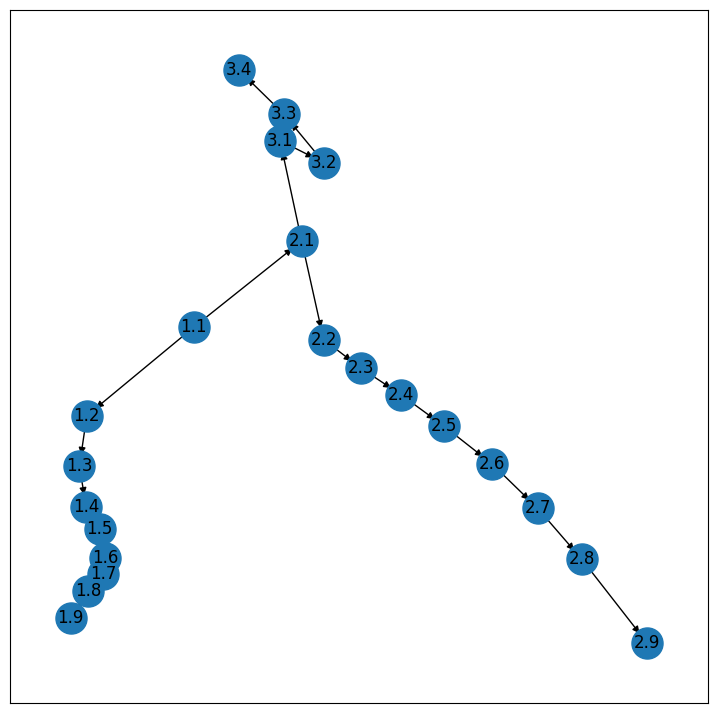

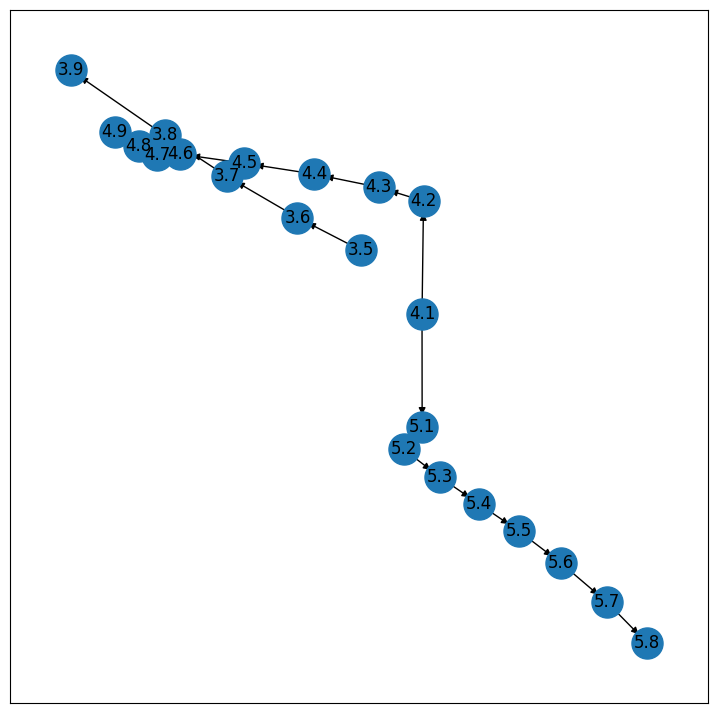

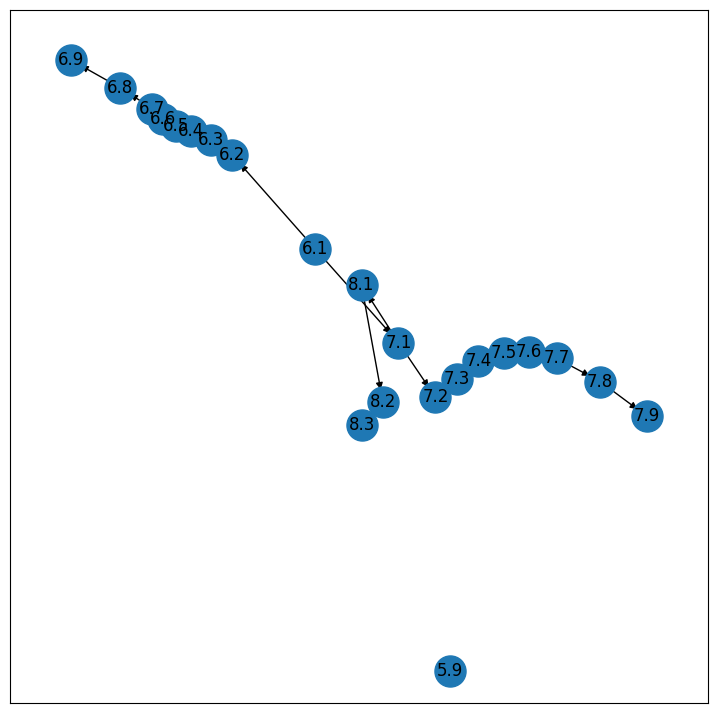

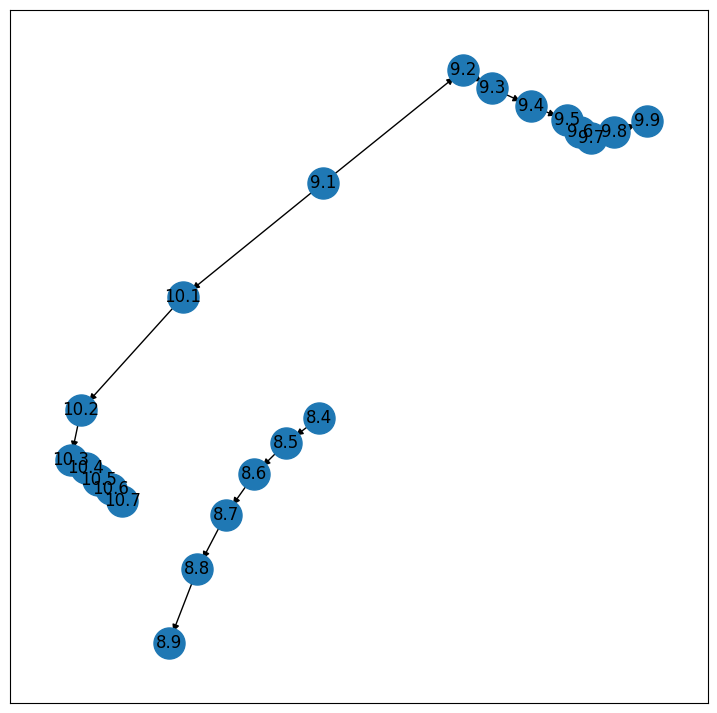

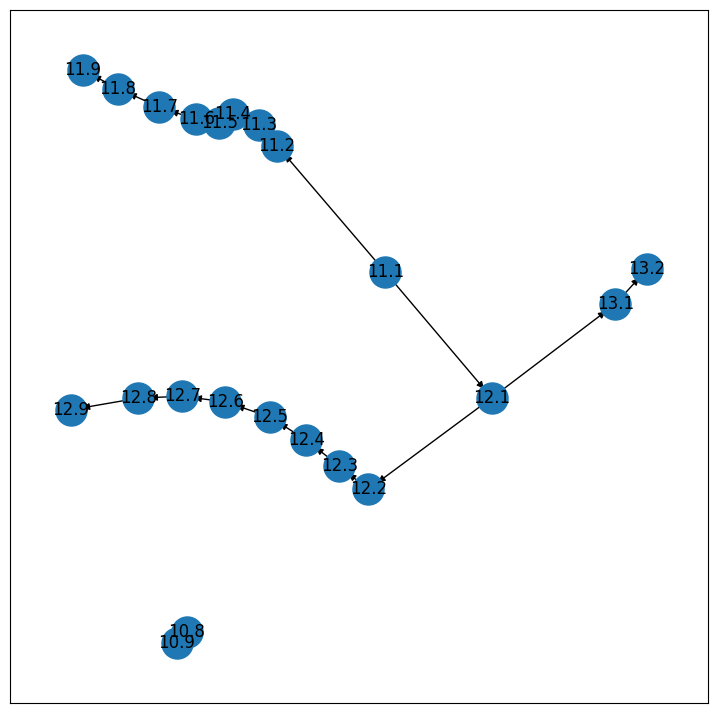

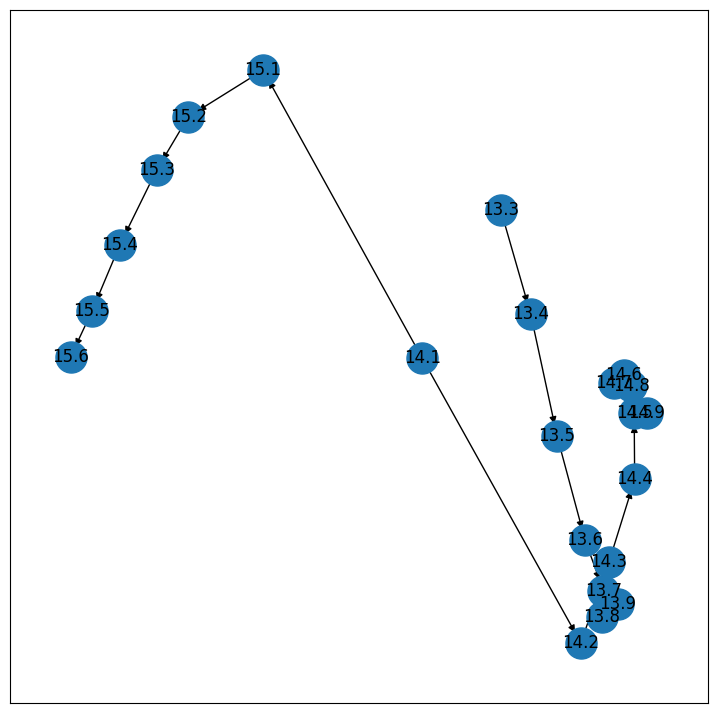

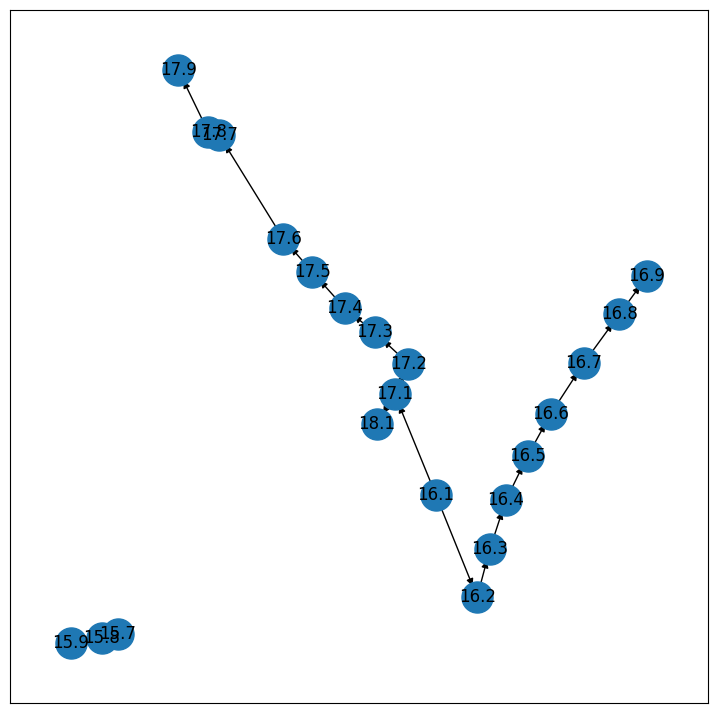

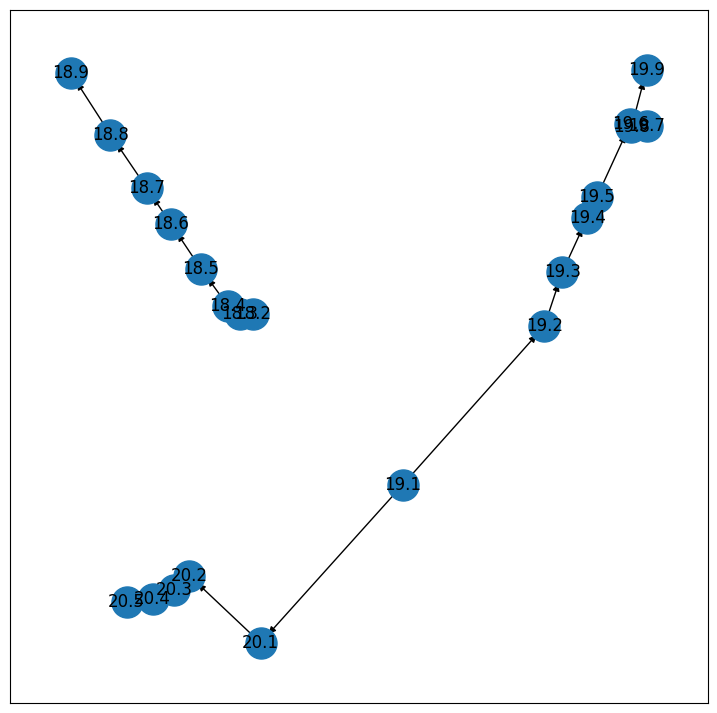

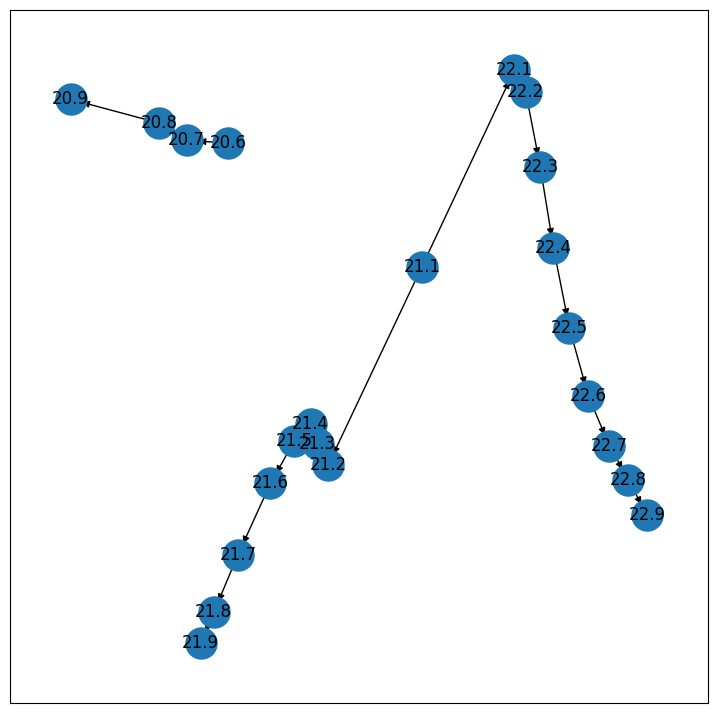

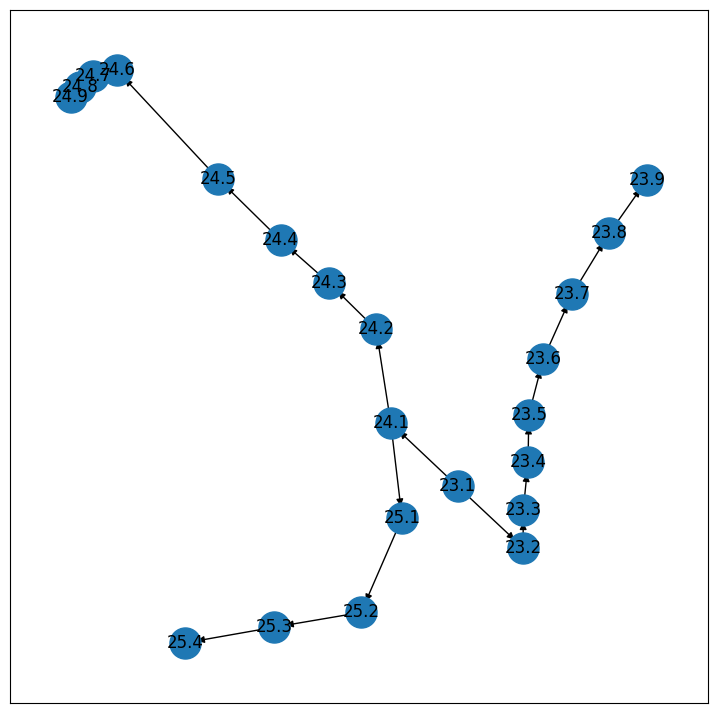

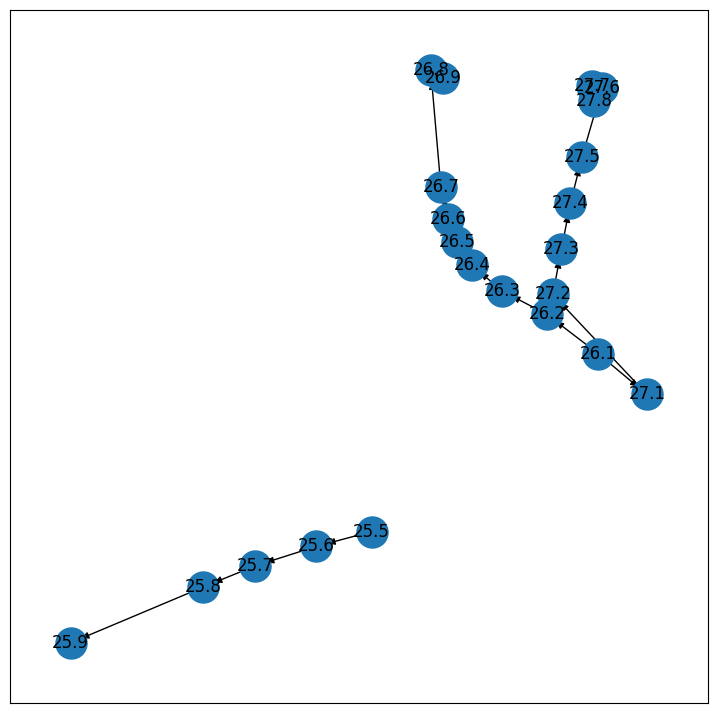

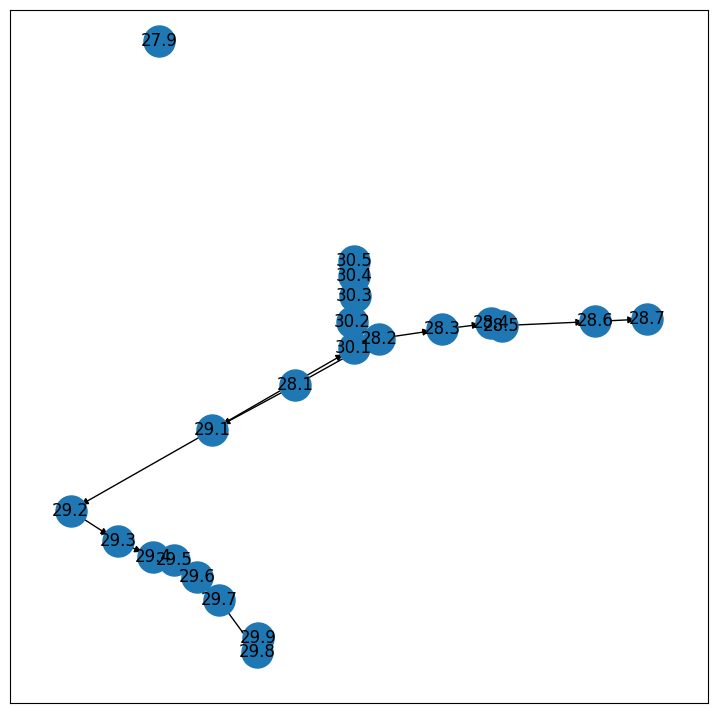

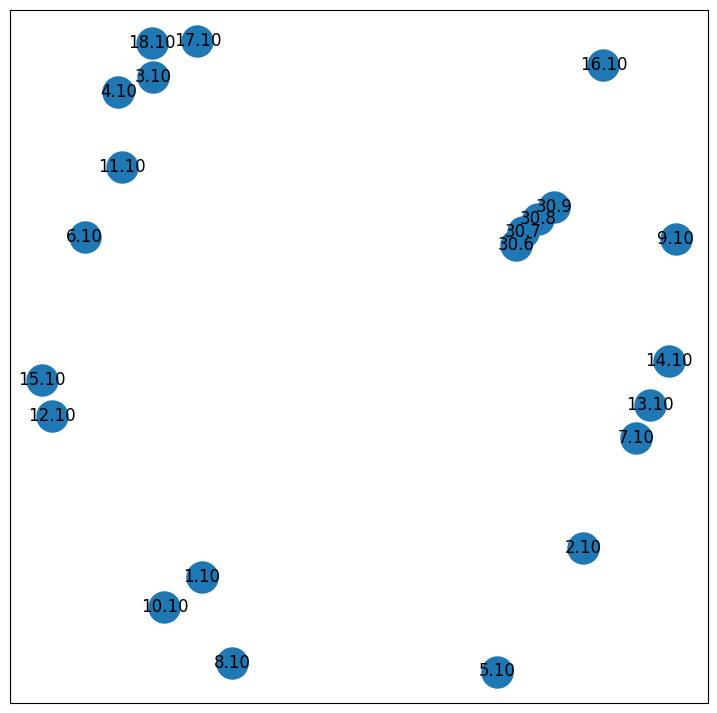

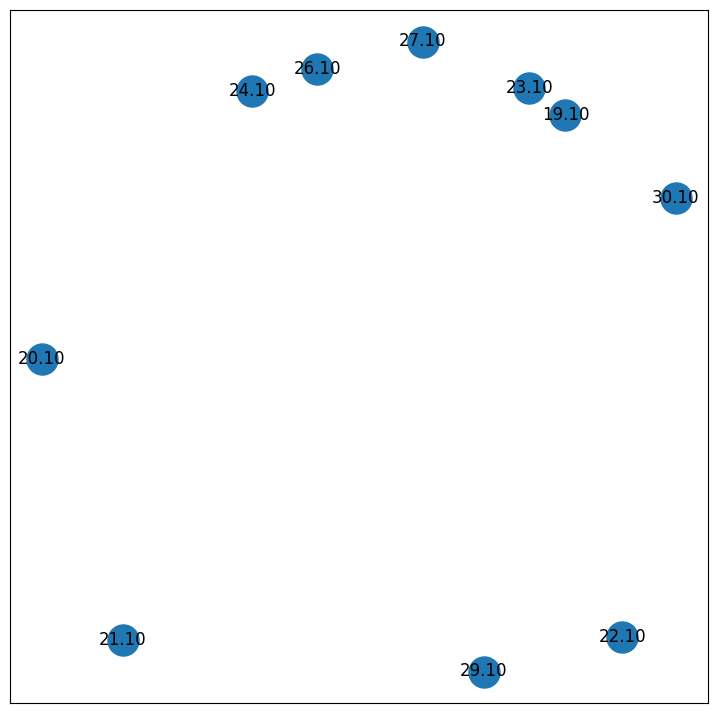

In [ ]:

#g.display_graph()